# Showcase: Naive Bayesian models

## (combined with PCA and/or feature maps)

## And an example of using sklearn's `Pipeline`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.ion()

In [2]:
K=10 # number of classes to load. Choose K=2 for binary classif.

In [3]:
# ######### les données ################
import sklearn.datasets
X,y = sklearn.datasets.load_digits(n_class=K, return_X_y=True)
# # np.savez_compressed("ManualLoad.npz", X=X, y=y)

# # this is the small dataset

import sklearn.model_selection
X,Xtest,y,ytest = sklearn.model_selection.train_test_split(X,y)

In [4]:
# these datafile are at: https://gitlab.inria.fr/flandes/data-for-teaching

LoadObject = np.load("/home/flandes/data/mnist70.npz")
Xbig = LoadObject['X']
ybig = LoadObject['y']
del LoadObject

Xbig,Xbig_test,ybig,ybig_test = sklearn.model_selection.train_test_split(Xbig,ybig)

## Advice on how to proceed
- take a look at a few pictures (=data points) (-> code is below)
- split your data in train / validation / test (or at least train+val vs. test)
- pre-process a bit the data by making it compatible with your hypothesis input space (e.g. if Bernoulli, input ought to be in the binary set {0,1}
- write your fit function
- write your prediction function
- fit and test your model
- display the confusion matrix of your results
- look at the weights learned, class by class. If you present them as pictures, do they make sense ? Is this a robust feature of image recognition, in your opinion? What would happen in imagenet, probably ?


## More advanced:
In addition to the above, 
- make a PCA as pre-processing step. Decrease dimension a lot.
- use a model with a non-trivial covariance matrix (or, equivalently (?), use a simple feature map).
- train this more advanced model


In [5]:
###########################
####  (pre processing) ####

import sklearn.preprocessing
import sklearn.decomposition
import sklearn.naive_bayes

In [6]:
?sklearn.preprocessing.PolynomialFeatures

In [7]:
# X, Xtest, y, ytest = Xbig,Xbig_test,ybig,ybig_test

In [16]:
X.shape

(1347, 64)

In [21]:
import sklearn.svm
?sklearn.svm.LinearSVC

In [23]:
Xt.shape, Xt2.shape, Xt3.shape

((1347, 63), (1347, 2017))

In [22]:
ncomp=20
ncomps = np.arange(1,64,2)
trainScores = np.zeros(len(ncomps))
valScores = np.zeros(len(ncomps))
for i, ncomp in enumerate(ncomps):
    myPCA = sklearn.decomposition.PCA(n_components=ncomp)
    Xt = myPCA.fit_transform(X)

    myPoly = sklearn.preprocessing.PolynomialFeatures(degree=2, interaction_only=True)
    Xt2 = myPoly.fit_transform(Xt)
    
    myScaler = sklearn.preprocessing.StandardScaler()
    Xt3 = myScaler.fit_transform(Xt2)

    ## finally, the classifier
    myBayes = sklearn.svm.LinearSVC()
    myBayes.fit(Xt3, y)

    ## apply the SAME transform to the validation set
    ## but WITHOUT using the validation data for training the parameters !
    ## even the parameters of the pre-processings should be learned using 
    ## only the train data (not the validation data)
    Xval3 = myScaler.transform(myPoly.transform( myPCA.transform(Xtest)))
    trainScores[i]= myBayes.score(Xt3, y)
    valScores[i]  = myBayes.score(Xval3, ytest)

/home/flandes/local_installs/mambaforge/envs/sandbox/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/flandes/local_installs/mambaforge/envs/sandbox/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/flandes/local_installs/mambaforge/envs/sandbox/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/flandes/local_installs/mambaforge/envs/sandbox/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/flandes/local_installs/mambaforge/envs/sandbox/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converg

In [18]:
Xt.shape

(1347, 63)

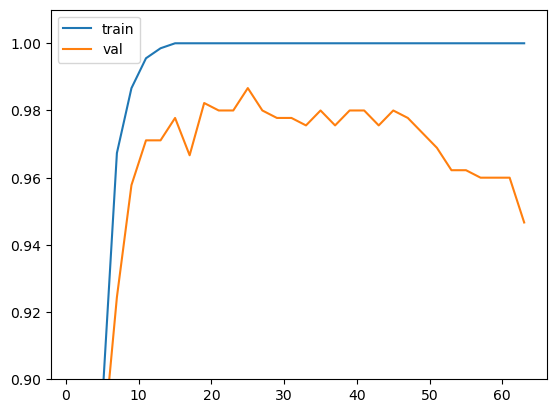

In [28]:
plt.plot(ncomps, trainScores, label="train")
plt.plot(ncomps, valScores, label="val")
plt.ylim([0.9,1.01])
plt.legend()

In [29]:
X.shape , Xt.shape , Xt2.shape , Xt3.shape

((1347, 64), (1347, 63), (1347, 2017), (1347, 2017))

In [12]:
#counting the number of features (poly degree 2, interaction only) with D=39
39*38/2 + 39 + 1

781.0

## Pipeline example 

# /!\

Here we have not used validation / test splits... you will see why soon:

In [13]:
## pipeline example:
n_components=5 # for the example
import sklearn.pipeline
steps=(("banana", sklearn.decomposition.PCA(n_components=n_components)), \
       ("featMap", sklearn.preprocessing.PolynomialFeatures(degree=2, interaction_only=True)),\
       ("standardization", sklearn.preprocessing.StandardScaler()),\
       ("NaiveBayes-Gaussian", sklearn.naive_bayes.GaussianNB())\
      )
myPipeline = sklearn.pipeline.Pipeline(steps=steps)
myPipeline.fit(X,y)

Pipeline(steps=[('PCA', PCA(n_components=5)),
                ('featMap', PolynomialFeatures(interaction_only=True)),
                ('standardization', StandardScaler()),
                ('NaiveBayes-Gaussian', GaussianNB())])

In [14]:
myPipeline.score(X,y), myPipeline.score(Xtest,ytest)

(0.8700816629547142, 0.8311111111111111)

## Pipeline example, continued

### Now we cross-validate automatically

In [15]:
import sklearn.pipeline
steps=(("banana", sklearn.decomposition.PCA()), \
       ("featMap", sklearn.preprocessing.PolynomialFeatures(degree=2, interaction_only=True)),\
       ("standardization", sklearn.preprocessing.StandardScaler()),\
       ("NaiveBayes-Gaussian", sklearn.naive_bayes.GaussianNB())\
      )
myPipeline = sklearn.pipeline.Pipeline(steps=steps)
# myPipeline.fit(X,y)

In [16]:
import sklearn.model_selection

In [17]:
param_range=np.arange(3,25,1,int)
param_range

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24])

In [41]:
train_scores, test_scores = sklearn.model_selection.validation_curve(
    myPipeline,
    X,
    y,
    param_name="banana__n_components",
    param_range=param_range,
    scoring="accuracy",
    n_jobs=2,
    cv=5
)

In [42]:
train_scores, test_scores

(array([[0.87465181, 0.8727948 , 0.87198516, 0.86827458, 0.87198516],
        [0.90157846, 0.89229341, 0.91001855, 0.89703154, 0.90352505],
        [0.92200557, 0.9275766 , 0.92486085, 0.92857143, 0.9257885 ],
        [0.93036212, 0.92386258, 0.92857143, 0.93042672, 0.93042672],
        [0.92943361, 0.93593315, 0.93320965, 0.932282  , 0.93970315],
        [0.92386258, 0.93964717, 0.93506494, 0.92857143, 0.932282  ],
        [0.92386258, 0.93221913, 0.93135436, 0.92486085, 0.93135436],
        [0.92850511, 0.93964717, 0.92949907, 0.92949907, 0.93042672],
        [0.93871866, 0.93686165, 0.9257885 , 0.93135436, 0.92949907],
        [0.92571959, 0.9461467 , 0.92022263, 0.93506494, 0.93413729]]),
 array([[0.87777778, 0.87037037, 0.87732342, 0.8401487 , 0.84386617],
        [0.88148148, 0.88518519, 0.92193309, 0.86245353, 0.866171  ],
        [0.91111111, 0.8962963 , 0.92936803, 0.90334572, 0.89962825],
        [0.91111111, 0.8962963 , 0.9330855 , 0.92193309, 0.9070632 ],
        [0.9148148

In [43]:
train_scores.shape, len(param_range)

((10, 5), 10)

In [33]:
def validation_curve_plot(train_scores, test_scores, title):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(r"$\gamma$")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(
        param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
    )
    plt.fill_between(
        param_range,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.2,
        color="darkorange",
        lw=lw,
    )
    plt.plot(
        param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw, ls="--"
    )
    plt.fill_between(
        param_range,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.2,
        color="navy",
        lw=lw,
    )
    plt.legend(loc="best")
    plt.show()

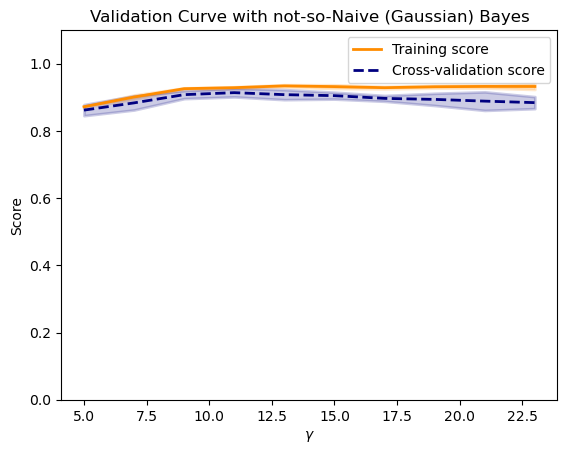

In [44]:
title = "Validation Curve with not-so-Naive (Gaussian) Bayes"
validation_curve_plot(train_scores, test_scores, title)

In [23]:
param_range[np.argmax(test_scores.mean(1))]

11

In [24]:
test_scores[np.argmax(test_scores.mean(1))]

array([0.91111111, 0.89259259, 0.92936803, 0.92193309, 0.9070632 ])

In [25]:
test_scores[np.argmax(test_scores.mean(1))].mean()

0.9124136031942724

## We could also do the grid search :

In [26]:
# param_grid = {
#     "PCA__n_components": [5, 15, 30, 45, 60]
# }
# search = sklearn.model_selection.GridSearchCV(myPipeline, param_grid, n_jobs=2)
# search.fit(X, y)

## Now we repeat it for the bigger dataset (larger N, larger D)

In [27]:
param_range=np.arange(5,25,2,int)

In [28]:
train_scoresBig, test_scoresBig = sklearn.model_selection.validation_curve(
    myPipeline,
    Xbig,
    ybig,
    param_name="PCA__n_components",
    param_range=param_range,
    scoring="accuracy",
    n_jobs=2,
    cv=5
)

In [32]:
train_scoresBig

array([[0.6465    , 0.64888095, 0.64797619, 0.64657143, 0.64935714],
       [0.70657143, 0.70840476, 0.708     , 0.70319048, 0.70859524],
       [0.72257143, 0.72366667, 0.72659524, 0.72190476, 0.72307143],
       [0.73102381, 0.73195238, 0.73416667, 0.72961905, 0.73195238],
       [0.73928571, 0.74147619, 0.74261905, 0.73859524, 0.74171429],
       [0.75071429, 0.75202381, 0.7532619 , 0.75138095, 0.753     ],
       [0.75380952, 0.75330952, 0.75411905, 0.7527381 , 0.75247619],
       [0.74940476, 0.74788095, 0.74757143, 0.74521429, 0.74692857],
       [0.75416667, 0.75421429, 0.75388095, 0.74928571, 0.75271429],
       [0.74940476, 0.7497381 , 0.75052381, 0.74816667, 0.74761905]])

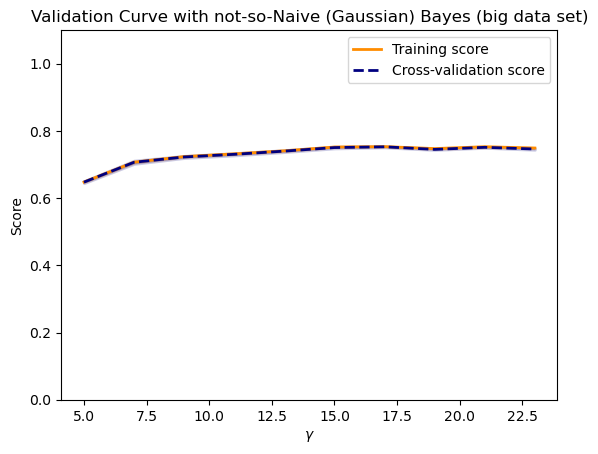

In [35]:
title = "Validation Curve with not-so-Naive (Gaussian) Bayes (big data set)"
validation_curve_plot(train_scoresBig, test_scoresBig, title)

In [36]:
test_scoresBig[np.argmax(test_scoresBig.mean(1))]

array([0.75114286, 0.75514286, 0.75190476, 0.75466667, 0.75066667])

In [37]:
test_scoresBig[np.argmax(test_scoresBig.mean(1))].mean()

0.7527047619047619

## If we use the Naive hypothesis, the results aren't so good:

In [38]:
direct = sklearn.naive_bayes.GaussianNB()
direct.fit(X,y)
direct.score(Xtest,ytest)


0.8377777777777777

In [39]:
direct = sklearn.naive_bayes.GaussianNB()
direct.fit(Xbig,ybig)
direct.score(Xbig_test,ybig_test)


0.5555428571428571

In [40]:
direct.score(Xbig,ybig), direct.score(Xbig_test,ybig_test)

(0.5591809523809523, 0.5555428571428571)

## But, with a bit of PCA, after all, they're pretty good !  Actually, better than with PCA+features+scaling  :(

### we choose simply $D'=D^{1/2}$ to get a first impression

In [45]:
import sklearn.pipeline
n_components=8
steps2=(("PCA", sklearn.decomposition.PCA(n_components=n_components)), \
       ("NaiveBayes-Gaussian", sklearn.naive_bayes.GaussianNB())\
      )
myPipeline2 = sklearn.pipeline.Pipeline(steps=steps2)
myPipeline2.fit(X,y)
myPipeline2.score(Xtest,ytest)

0.88

In [46]:
import sklearn.pipeline
n_components=28
steps2=(("PCA", sklearn.decomposition.PCA(n_components=n_components)), \
       ("NaiveBayes-Gaussian", sklearn.naive_bayes.GaussianNB())\
      )
myPipeline2 = sklearn.pipeline.Pipeline(steps=steps2)
myPipeline2.fit(Xbig,ybig)
myPipeline2.score(Xbig_test,ybig_test)

0.8566285714285714

## and with a bit of search for the best n_comp:

In [47]:
param_range=np.arange(5,50,5,int)

In [48]:
train_scoresNaif, test_scoresNaif = sklearn.model_selection.validation_curve(
    myPipeline2,
    X,
    y,
    param_name="PCA__n_components",
    param_range=param_range,
    scoring="accuracy",
    n_jobs=4,
    cv=5
)

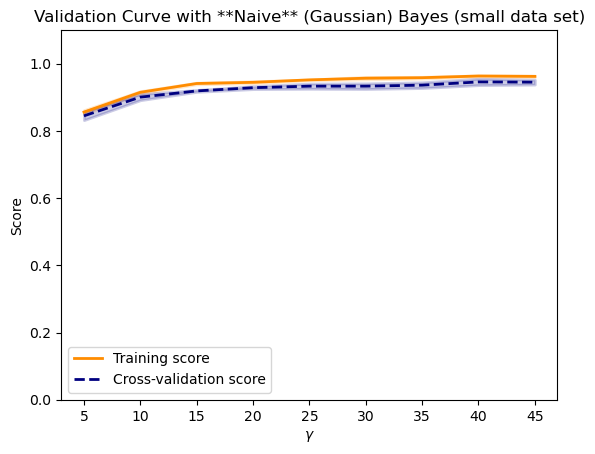

In [49]:
title = "Validation Curve with **Naive** (Gaussian) Bayes (small data set)"
validation_curve_plot(train_scoresNaif, test_scoresNaif, title)

In [50]:
test_scoresNaif[np.argmax(test_scoresNaif.mean(1))]

array([0.94074074, 0.93703704, 0.95539033, 0.93680297, 0.95910781])

In [51]:
test_scoresNaif[np.argmax(test_scoresNaif.mean(1))].mean()

0.9458157786038827

## and finally, for the big data set, similar result:

In [52]:
param_range=np.arange(5,50,5,int)

In [53]:
train_scoresBig, test_scoresBig = sklearn.model_selection.validation_curve(
    myPipeline2,
    Xbig,
    ybig,
    param_name="PCA__n_components",
    param_range=param_range,
    scoring="accuracy",
    n_jobs=2,
    cv=5
)

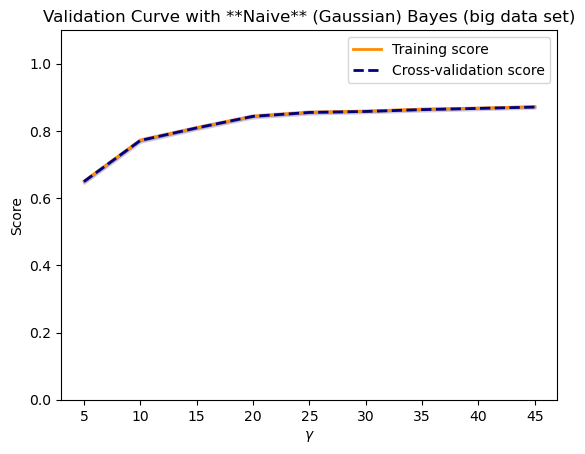

In [54]:
title = "Validation Curve with **Naive** (Gaussian) Bayes (big data set)"
validation_curve_plot(train_scoresBig, test_scoresBig, title)

In [71]:
test_scoresBig[np.argmax(test_scoresBig.mean(1))]

array([0.86809524, 0.87009524, 0.87333333, 0.86504762, 0.8712381 ])

In [72]:
test_scoresBig[np.argmax(test_scoresBig.mean(1))].mean()

0.8695619047619049

# Conclusion: in these data sets, the PCA is the key pre-procesing - the feature map afterwards doesn't help -- or we don't have enough data to take advantage of it !